In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import time
from typing import Sequence

import matplotlib.pyplot as plt
import numpy as np
import torch

from janelia_core.ml.utils import torch_mod_to_fcn

from sparse_networks import CenteredBumpFcn
from sparse_networks import FunctionSequenceGenerator
from sparse_networks import plot_2d_f
from sparse_networks import SumOfBumpFcns


## Define objects

In [3]:
class NNNetwork(torch.nn.Module):
    """ Nearest neighbor network"""
    
    def __init__(self, init_ctrs: torch.Tensor, fcns: Sequence, k: int = 1):
        """ Creates a new NNNetwork. 
        
        Args:
        
            init_ctrs: Initial centeres for each function. Of shape n_ctrs*input_dim
            
            fcns: Functions to associate with each enter. 
            
            n: Number of nearest neighbors to use. 
        """
        
        super().__init__()
        self.k = k
        self.n_fcns = len(fcns)
        
        init_ctr_shape = init_ctrs.shape
        
        self.ctrs = torch.nn.Parameter(torch.reshape(init_ctrs, [init_ctr_shape[0], 1, init_ctr_shape[1]]))
        self.fcns = torch.nn.ModuleList(fcns)
        
        # Determine dimensionality of output
        #test_out = fcns[0](init_ctrs[0:1,:])
        #if test_out.ndim == 1:
        #    self.d_out = 1
        #else:
        #    self.d_out = fcns[0](init_ctrs[0:1,:]).shape[1]
        
    def forward(self, x: torch.Tensor):
        """ Computes output from input. 
        
        Args:
        
            x: Input of shape n_smps*input_dim
            
        Returns: 
            y: Output of shape n_smps*output_dim
        """
        
        # Find k-nearest neighbor functions to each input point
        with torch.no_grad():
            sq_distances = torch.sum((x - self.ctrs)**2, dim=2)  
            top_k_indices = torch.topk(-sq_distances, k=self.k, dim=0).indices
            
        # Form output
        n_input_smps = x.shape[0]
        #y = torch.zeros([n_input_smps, self.d_out])
        y = torch.zeros(n_input_smps, device=x.device)
        for i in range(self.n_fcns):
            cur_smps = torch.any(top_k_indices == i, dim=0)
            
            centered_smps = x[cur_smps,:] - self.ctrs[i, 0, :].squeeze()
            y_smps = self.fcns[i](centered_smps)
            y[cur_smps] += self.fcns[i](centered_smps) #.unsqueeze(1)
        
        return y
    
    def bound(self, ctr_bounds: Sequence = [0, 1], bound_fcns: bool =  True):
        """  Applies bounds to the centers.

        Bounds are applied element-wise.

        Args:

            ctr_bounds: The bounds to force centers to be between. If None, no bounds are enforced.
            
            bound_fcns: True if bound should be called on functiions. 

        """

        if ctr_bounds is not None:
            small_inds = self.ctrs < ctr_bounds[0]
            big_inds = self.ctrs > ctr_bounds[1]
            self.ctrs.data[small_inds] = ctr_bounds[0]
            self.ctrs.data[big_inds] = ctr_bounds[1]
        
        if bound_fcns:
            for f in self.fcns:
                f.bound()


In [4]:
class linear_nn(torch.nn.Module):
    
    def __init__(self, d: int):
        
        super().__init__()
        
        self.w = torch.nn.Parameter(torch.ones(d))
        self.o = torch.nn.Parameter(torch.zeros(1))
        torch.nn.init.normal_(self.w)
        
    def forward(self, x):
        
        return torch.matmul(x, self.w) + self.o
    
    def bound(self):
        pass

## Fitting function

In [5]:
def fit(nn: torch.nn.Module, x: torch.Tensor, y: torch.Tensor, n_its = 1000, lr=.01, batch_size: int = None, 
        enforce_bounds: bool = True, update_int: int = 1000):
    """ Fits a neural network. 
    
    Args:
        x: Input data of shape n_smps*d_in
        
        y: Output data of shape n_smps*1
        
        n_its: The number of iterations to run optimization for
        
        lr: The learning rate to use
        
        enforce_bounds: If true, the center of bump functions will be
        constrained to stay in the unit hypercube
        
        update_int: Interval updates are printed
    
    """
    
    params = nn.parameters()
    
    optimizer = torch.optim.Adam(params = params, lr=lr)
    
    n_smps = x.shape[0]
    if batch_size is None:
        batch_size = n_smps
    
    for i in range(n_its):
        
        # Select samples for this iteration 
        if batch_size != n_smps:
            inds = torch.randperm(n_smps)[1:batch_size]
            batch_x = x[inds, :]
            batch_y = y[inds]
        else:
            batch_x = x
            batch_y = y
        
        optimizer.zero_grad()
        
        y_pred = nn(batch_x)
        er = torch.sum((batch_y - y_pred)**2)/batch_size
        er.backward()
        
        optimizer.step()
        
        if enforce_bounds:
            nn.bound()
        
        if i % update_int == 0:
            er_log = float(er.detach().cpu().numpy())
            print('It ' + str(i) +  ': {:e}'.format(er_log))
    

## Generate a ground-truth function we want to fit and visualize it

In [6]:
fcn_generator = FunctionSequenceGenerator(n_bumps = 50, bump_peak_vl_range = [-1, 1], cov_ev_range = [.002, .002])
f_true = fcn_generator.generate(1)

x = np.random.rand(10000,2)
y = f_true(x)

x = torch.tensor(x, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.float32)

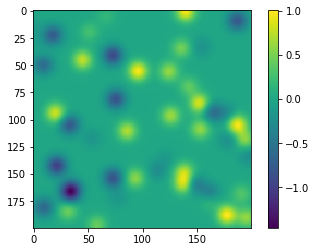

In [7]:
plot_2d_f(f_true, n_smps_per_dim=200)

## Now fit the function

In [16]:
run_on_gpu = False
n_fcns = 300

In [17]:
init_ctrs = torch.rand(n_fcns, 2)
#init_fcns = [CenteredBumpFcn(band_widths=1*torch.ones(2), mag=0) for i in range(n_fcns)]
init_fcns = [linear_nn(2) for i in range(n_fcns)]
fit_f = NNNetwork(init_ctrs=init_ctrs, fcns=init_fcns, k=1)

In [18]:
fit_f.k = 1

In [19]:
if run_on_gpu:
    fit_f.to('cuda')
    x = x.to('cuda')
    y = y.to('cuda')
else:
    fit_f.to('cpu')
    x = x.to('cpu')
    y = y.to('cpu')

In [20]:
lr = .01
enforce_bounds=True
batch_size = 5000

t0 = time.time()

fit(fit_f, x, y, n_its = 1000, lr=lr, batch_size=batch_size, enforce_bounds=enforce_bounds, update_int=100)
    
t_stop = time.time()

print('Elapsed time: ' + str(t_stop - t0))

It 0: 5.874592e-02
It 100: 2.732644e-02
It 200: 2.041933e-02
It 300: 1.726808e-02
It 400: 1.540994e-02
It 500: 1.263501e-02
It 600: 1.216435e-02
It 700: 1.073275e-02
It 800: 9.466493e-03
It 900: 8.573979e-03
Elapsed time: 294.46670389175415


In [21]:
fit_f.to('cpu') 
x = x.to('cpu')
y = y.to('cpu')

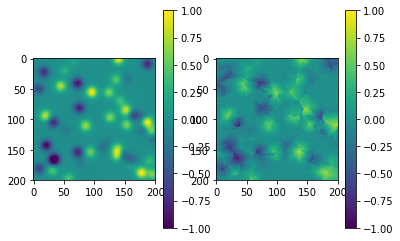

In [22]:
plt.subplot(1,2,1)
plot_2d_f(f_true, n_smps_per_dim=200)
plt.gca().get_images()[0].set_clim(-1,1)
plt.subplot(1,2,2)
plot_2d_f(torch_mod_to_fcn(fit_f), n_smps_per_dim=200)
plt.gca().get_images()[0].set_clim(-1,1)